# Assignment 3

Reinforcement learning techniques for the control of a battery energy storage system in the real-time electricity market

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Data preparation

**Hourly market prices of zone DK1 (DKK) from 1/1/21 0:00 to 9/18/23 23:00.**

Selected PriceArea: DK1         
Selected Price: DKK         
Starting Date: 1/1/21 0:00              
Ending Date: 9/18/23 23:00

In [87]:
# read an xlsx file
raw_data = pd.read_excel('Price.xlsx', sheet_name="Clean Data")
raw_data

,HourDK,PriceDKK,Category
0,2021-01-01 00:00:00,378.519989,Very Low
1,2021-01-01 01:00:00,358.579987,Very Low
2,2021-01-01 02:00:00,332.459991,Very Low
3,2021-01-01 03:00:00,319.369995,Very Low
4,2021-01-01 04:00:00,300.540009,Very Low
...,...,...,...
23778,2023-09-18 19:00:00,410.589996,Very Low
23779,2023-09-18 20:00:00,610.030029,Low
23780,2023-09-18 21:00:00,222.779999,Very Low
23781,2023-09-18 22:00:00,202.419998,Very Low


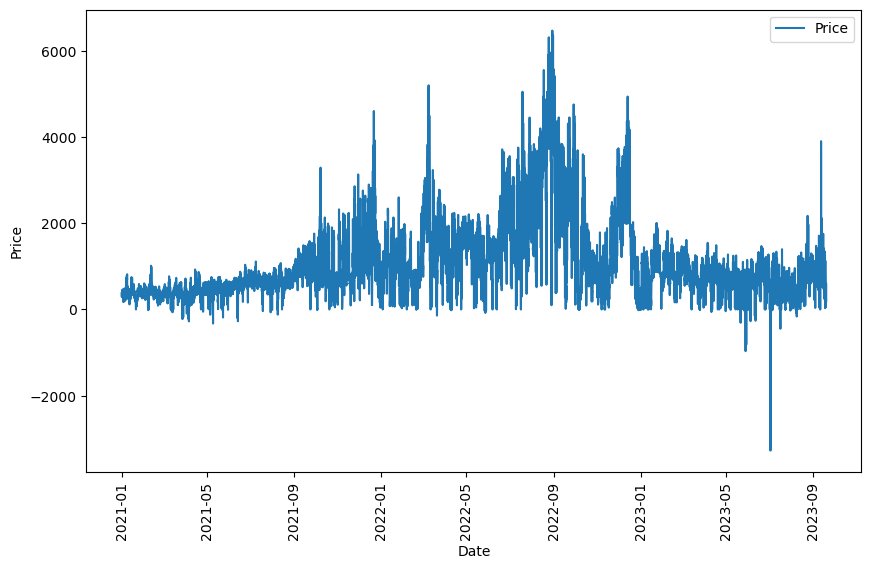

In [88]:
# plot the price with respect to the date
plt.figure(figsize=(10, 6))
plt.plot(raw_data['HourDK'], raw_data['PriceDKK'], label='Price')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [89]:
# Calculate characteristics of price categories
Price_categories = ["Very Low","Low", "Medium", "High", "Very High"]

avg = raw_data.groupby('Category')['PriceDKK'].mean().reset_index().sort_values(by='PriceDKK', ascending=True).reset_index(drop=True)
min = raw_data.groupby('Category')['PriceDKK'].min().reset_index().sort_values(by='PriceDKK', ascending=True).reset_index(drop=True)
max = raw_data.groupby('Category')['PriceDKK'].max().reset_index().sort_values(by='PriceDKK', ascending=True).reset_index(drop=True)
count = raw_data.groupby('Category')['PriceDKK'].count().reset_index()
count['Category'] = pd.Categorical(count['Category'], categories=Price_categories, ordered=True)
count = count.sort_values(by='Category').reset_index(drop=True)

total_count = raw_data.count()['PriceDKK']

min_price = {cat: min['PriceDKK'][Price_categories.index(cat)] for cat in Price_categories}
max_price = {cat: max['PriceDKK'][Price_categories.index(cat)] for cat in Price_categories}
avg_price = {cat: avg['PriceDKK'][Price_categories.index(cat)] for cat in Price_categories}
prop_cat = {cat: count['PriceDKK'][Price_categories.index(cat)] for cat in Price_categories}

# Print average prices
for cat in Price_categories:
    print(cat,": [", round(min_price[cat],2),",", round(max_price[cat],2),"]", "Average:", avg_price[cat], "Proportion:", round(prop_cat[cat]/total_count*100,3), "%" )
 

Very Low : [ -3277.39 , 414.7 ] Average: 227.97914865125077 Proportion: 20.002 %
Low : [ 414.76 , 654.23 ] Average: 539.5933643149706 Proportion: 19.997 %
Medium : [ 654.25 , 894.97 ] Average: 761.680966905823 Proportion: 20.002 %
High : [ 895.01 , 1480.51 ] Average: 1151.921623339571 Proportion: 19.997 %
Very High : [ 1480.53 , 6478.24 ] Average: 2438.8812172703388 Proportion: 20.002 %


## Definition of helping functions

- split_data()

- get_transition_matrix()

- reward()

- evaluate_policy()

- iterate_policy()

- get_policy_results()

- plot_results()

In [90]:
def split_data(data, validation=False):
    """
    Split the complete dataset into training, testing and validation (optional) sets.

    Arguments:
        data
    
    Returns:
        train_data, test_data, validation_data
    """
    # split into training, validation, and test sets
    train_size = int(len(data) * 0.7)
    validation_size = int(len(data) * 0.15)
    test_size = len(data) - train_size - validation_size
    train_data = data[0:train_size]

    if validation:
        validation_data = data[train_size:train_size+validation_size]
        test_data = data[train_size+validation_size:]
    else:
        validation_data = []
        test_data = data[train_size:]

    return train_data, test_data, validation_data

In [91]:
def get_transition_matrix(data, SOC_states: list[int], Price_states: list[str], Power=100):
    """
    Computes the state transition matrix.

    Arguments:
        data, SOC_states, Price_states, Power

    Returns:
        price_transition_probability, transition_probability
    """
    # calculating the probability of the price state transition
    condition_count = 0
    transition_count = 0
    price_transition_probability = {}
    for current_state in Price_states:
        for next_state in Price_states:
                for index in range(len(data)-1):
                    if data["Category"][index] == current_state:
                        condition_count += 1
                        if data["Category"][index+1] == next_state:
                            transition_count += 1
                price_transition_probability[(current_state, next_state)] = transition_count / condition_count
                condition_count = 0
                transition_count = 0

    # defining the state (SOC, Price) probabilities
    transition_probability = pd.DataFrame(index=[(soc, price) for soc in SOC_states for price in Price_states], columns=[(soc, price) for soc in SOC_states for price in Price_states]) 
    transition_probability = transition_probability.applymap(lambda x: (0, 0, 0)) # Initialize the transition probability dataframe with a tuple with 3 zero elements, representing Charge, Idle, and Discharge
    for i, current_state in enumerate(transition_probability.index):
        for next_state in transition_probability.columns:
            if next_state[0] == current_state[0] + Power: # when charging, the power increases the SOC by Power
                transition_probability.iloc[i][next_state] = (price_transition_probability[(current_state[1], next_state[1])], 0, 0) # the probability is taken from the price_transition_probability dictionary
            elif next_state[0] == current_state[0]:
                transition_probability.iloc[i][next_state] = (0, price_transition_probability[(current_state[1], next_state[1])], 0)
            elif next_state[0] == current_state[0] - Power:
                transition_probability.iloc[i][next_state] = (0, 0, price_transition_probability[(current_state[1], next_state[1])])

    return price_transition_probability, transition_probability

In [92]:
def reward(price:float, action:str, Power=100):
    """
    Computes the reward associated to an action and the corresponding environment

    Arguments:
        price, action, Power=100

    Returns: 
        reward
    """
    reward = 0

    if action == "Charge":
        reward = -Power * price
    elif action == "Discharge":
        reward = Power * price
    else:
        reward = 0

    return reward

In [93]:
# defining a function to evaluate the policy
def evaluate_policy(policy, states, actions, transition_probability, discount_factor, Power=100):
    """
    Arguments:
        policy, states, actions, transition_probability, discount_factor, Power=100

    Returns:
        value_function
    """
    # initialize the transition and reward matrices
    transition_matrix = np.zeros((len(states), len(states)))
    reward_matrix = np.zeros(len(states))
    for s in range(len(states)):
        reward_matrix[s] = reward(avg_price[states[s][1]], policy[s], Power)
        transition_all_action = np.array(transition_probability.iloc[s,:]) # extract the transition probabilities for all actions
        transition_one_action = np.array([]) # initialize the transition probabilities for one action
        for item in transition_all_action: # extract the transition probabilities for one action
            transition_one_action = np.append(transition_one_action, item[actions.index(policy[s])])
        transition_matrix[s] = transition_one_action # assign the transition probabilities for one action to the transition matrix
        # print(f"state: {states[s]}, policy: {policy[s]}")
        # print(sum(transition_matrix[s]))
    
    # calculate the value function
    value_function = np.linalg.inv(np.eye(len(states)) - discount_factor * transition_matrix).dot(reward_matrix)
    
    return value_function

In [94]:
# defining policy iteration
def iterate_policy(states, actions, data, transition_probability, discount_factor=0.9, Power=100, print_iter=True):
    """
    Policy iteration algorithm

    Arguments:
        states, actions, data, transition_probability, discount_factor=0.9, Power=100, print_iter=True

    Returns:
        policy, value_function
    """
    # initialize the policy randomly
    policy = np.random.choice(actions, len(states))
    # evaluate the policy
    value_function = evaluate_policy(policy, states, actions, transition_probability, discount_factor, Power)
    # initialize the policy_stable as False
    policy_stable = False
    iteration = 0

    # iterate until the policy is stable
    while not policy_stable:
        # initialize the policy_stable as True
        policy_stable = True
        for s in range(len(states)):
            old_action = policy[s]
            # calculate the Q-value
            # initialize the Q-values as negative infinity
            Q_values = np.full(len(actions), -np.inf)
            for a in range(len(actions)):
                # limit the actions to the possible ones
                if (states[s][0] == 0 and actions[a] == "Discharge") or (states[s][0] == 500 and actions[a] == "Charge"):
                    continue
                reward_s_a = reward(avg_price[states[s][1]], actions[a], Power)
                transition_all_action = np.array(transition_probability.iloc[s,:])
                transition_one_action = np.array([])
                for item in transition_all_action:
                    transition_one_action = np.append(transition_one_action, item[a])
                Q_values[a] = reward_s_a + discount_factor * np.dot(transition_one_action, value_function) # multiply or sum?
            # update the policy
            policy[s] = actions[np.argmax(Q_values)]
            # check if the policy is stable
            if old_action != policy[s]:
                policy_stable = False
        # evaluate the policy
        value_function = evaluate_policy(policy, states, actions, transition_probability, discount_factor, Power)
        # show the iteration number
        iteration += 1
    if print_iter:
        print(f"Has converged in {iteration} iterations.")

        
    return policy, value_function

In [95]:
def get_policy_results(data, policy, discount_factor):
    """ 
    Test of the optimal policy 
    
    Arguments:
        data, policy, discount_factor

    Returns:
        df_SOC: policy results
    """
    df_SOC = pd.DataFrame(0, index=range(len(data)),columns=["SOC","Price","Price_cat","Action","Gain","Acc_gain"])
    df_SOC["Price_cat"] = data["Category"]
    df_SOC["Price"] = data["PriceDKK"]

    # Start with a SOC of 0
    df_SOC.loc[0,"SOC"] = 0

    # For all hours, calculate the action, new state and the reward thanks to last SOC, current Price
    # SOC_h-1 , price_h = SOC_h
    for i in range(1,len(df_SOC)):
        
        SOC = df_SOC["SOC"][i-1]
        price = df_SOC["Price_cat"][i]
        
        a = policy[SOC][price]
        df_SOC.loc[i,"Action"] = a

        if a == "Idle":
            next_SOC = SOC
        elif a == "Charge":
            next_SOC = SOC + 100
        else:
            next_SOC = SOC - 100
        
        df_SOC.loc[i,"SOC"] = next_SOC
        df_SOC.loc[i,"Gain"] = reward(df_SOC["Price"][i], a)
        df_SOC.loc[i,"Acc_gain"] = df_SOC["Acc_gain"][i-1] + df_SOC["Gain"][i]

    # Print the accumulated gain
    print(f"Accumulated gain for gamma = {discount_factor}:", "{:.2e}".format(df_SOC["Acc_gain"][len(df_SOC)-1]))

    return df_SOC


In [96]:
def plot_results(i_start:int, i_end:int, policy_results, cat_num=3):
    """
    Plot associated graphs to the policy results

    Arguments:
        i_start, i_end, policy_results, cat_num
    """
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('SOC', color=color)
    ax1.plot(policy_results[i_start:i_end].index, policy_results["SOC"][i_start:i_end], color=color,drawstyle='steps-post',label="SOC")
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(ymin=-20, ymax=520)
    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Price', color=color)  # we already handled the x-label with ax1
    ax2.plot(policy_results[i_start:i_end].index, policy_results["Price"][i_start:i_end], color=color,label="Market price")
    ax2.tick_params(axis='y', labelcolor=color)

    if cat_num == 3:
        ax2.axhline(y=min_price["Low"],label="Price categories interval",linestyle = 'dotted')
        ax2.axhline(y=max_price["High"],linestyle = 'dotted')
    elif cat_num == 5:
        ax2.axhline(y=min_price["Low"],label="Price categories interval",linestyle = 'dotted')
        ax2.axhline(y=min_price["Medium"],linestyle = 'dotted')
        ax2.axhline(y=min_price["High"],linestyle = 'dotted')
        ax2.axhline(y=min_price["Very High"],linestyle = 'dotted')
    ax2.legend(loc="upper right")

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


## Implementation of value and policy iteration algorithms

### Policy iteration algorithm

In [97]:
""" 5 price categories """

# defining States
SOC_states = [soc for soc in range(0, 501, 100)]
Price_states = ["Very Low","Low", "Medium", "High", "Very High"]
All_states = [(soc, price) for soc in SOC_states for price in Price_states]

# defining Actions
Actions = ["Charge", "Idle", "Discharge"]
Power = 100

In [98]:
# Calculate characteristics of price categories
Price_categories = Price_states

avg = raw_data.groupby('Category')['PriceDKK'].mean().reset_index().sort_values(by='PriceDKK', ascending=True).reset_index(drop=True)
avg_price = {cat: avg['PriceDKK'][Price_categories.index(cat)] for cat in Price_categories}

# Print average prices
for cat in Price_categories:
    print(cat, "- Average:", avg_price[cat])
 

Very Low - Average: 227.97914865125077
Low - Average: 539.5933643149706
Medium - Average: 761.680966905823
High - Average: 1151.921623339571
Very High - Average: 2438.8812172703388


In [99]:
# splitting dataset
train_data, test_data, validation_data = split_data(raw_data, validation=False)

# defining state transition matrix
price_transition_probability, transition_probability = get_transition_matrix(raw_data, SOC_states, Price_states, Power)

In [100]:
# price transition matrix (between two price categories/states)
price_transition_probability

{('Very Low', 'Very Low'): 0.894869638351556,
 ('Very Low', 'Low'): 0.09629941126997477,
 ('Very Low', 'Medium'): 0.007359125315391085,
 ('Very Low', 'High'): 0.001471825063078217,
 ('Very Low', 'Very High'): 0.0,
 ('Low', 'Very Low'): 0.10029436501261564,
 ('Low', 'Low'): 0.7741799831791422,
 ('Low', 'Medium'): 0.11501261564339782,
 ('Low', 'High'): 0.01030277544154752,
 ('Low', 'Very High'): 0.00021026072329688813,
 ('Medium', 'Very Low'): 0.0037838974143367668,
 ('Medium', 'Low'): 0.12549926424216942,
 ('Medium', 'Medium'): 0.7611940298507462,
 ('Medium', 'High'): 0.10700021021652302,
 ('Medium', 'Very High'): 0.002522598276224511,
 ('High', 'Very Low'): 0.0010513036164844407,
 ('High', 'Low'): 0.003994953742640875,
 ('High', 'Medium'): 0.11564339781328847,
 ('High', 'High'): 0.8019343986543314,
 ('High', 'Very High'): 0.07737594617325484,
 ('Very High', 'Very Low'): 0.0,
 ('Very High', 'Low'): 0.0,
 ('Very High', 'Medium'): 0.0008408660920748371,
 ('Very High', 'High'): 0.079251629

In [101]:
# state transition matrix (between two states: SOC, price) combined with the corresponding action (Discharge, Idle, Charge)
transition_probability

,"(0, Very Low)","(0, Low)","(0, Medium)","(0, High)","(0, Very High)","(100, Very Low)","(100, Low)","(100, Medium)","(100, High)","(100, Very High)",...,"(400, Very Low)","(400, Low)","(400, Medium)","(400, High)","(400, Very High)","(500, Very Low)","(500, Low)","(500, Medium)","(500, High)","(500, Very High)"
"(0, Very Low)","(0, 0.894869638351556, 0)","(0, 0.09629941126997477, 0)","(0, 0.007359125315391085, 0)","(0, 0.001471825063078217, 0)","(0, 0.0, 0)","(0.894869638351556, 0, 0)","(0.09629941126997477, 0, 0)","(0.007359125315391085, 0, 0)","(0.001471825063078217, 0, 0)","(0.0, 0, 0)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
"(0, Low)","(0, 0.10029436501261564, 0)","(0, 0.7741799831791422, 0)","(0, 0.11501261564339782, 0)","(0, 0.01030277544154752, 0)","(0, 0.00021026072329688813, 0)","(0.10029436501261564, 0, 0)","(0.7741799831791422, 0, 0)","(0.11501261564339782, 0, 0)","(0.01030277544154752, 0, 0)","(0.00021026072329688813, 0, 0)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
"(0, Medium)","(0, 0.0037838974143367668, 0)","(0, 0.12549926424216942, 0)","(0, 0.7611940298507462, 0)","(0, 0.10700021021652302, 0)","(0, 0.002522598276224511, 0)","(0.0037838974143367668, 0, 0)","(0.12549926424216942, 0, 0)","(0.7611940298507462, 0, 0)","(0.10700021021652302, 0, 0)","(0.002522598276224511, 0, 0)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
"(0, High)","(0, 0.0010513036164844407, 0)","(0, 0.003994953742640875, 0)","(0, 0.11564339781328847, 0)","(0, 0.8019343986543314, 0)","(0, 0.07737594617325484, 0)","(0.0010513036164844407, 0, 0)","(0.003994953742640875, 0, 0)","(0.11564339781328847, 0, 0)","(0.8019343986543314, 0, 0)","(0.07737594617325484, 0, 0)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
"(0, Very High)","(0, 0.0, 0)","(0, 0.0, 0)","(0, 0.0008408660920748371, 0)","(0, 0.0792516291780534, 0)","(0, 0.9199075047298718, 0)","(0.0, 0, 0)","(0.0, 0, 0)","(0.0008408660920748371, 0, 0)","(0.0792516291780534, 0, 0)","(0.9199075047298718, 0, 0)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
"(100, Very Low)","(0, 0, 0.894869638351556)","(0, 0, 0.09629941126997477)","(0, 0, 0.007359125315391085)","(0, 0, 0.001471825063078217)","(0, 0, 0.0)","(0, 0.894869638351556, 0)","(0, 0.09629941126997477, 0)","(0, 0.007359125315391085, 0)","(0, 0.001471825063078217, 0)","(0, 0.0, 0)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
"(100, Low)","(0, 0, 0.10029436501261564)","(0, 0, 0.7741799831791422)","(0, 0, 0.11501261564339782)","(0, 0, 0.01030277544154752)","(0, 0, 0.00021026072329688813)","(0, 0.10029436501261564, 0)","(0, 0.7741799831791422, 0)","(0, 0.11501261564339782, 0)","(0, 0.01030277544154752, 0)","(0, 0.00021026072329688813, 0)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
"(100, Medium)","(0, 0, 0.0037838974143367668)","(0, 0, 0.12549926424216942)","(0, 0, 0.7611940298507462)","(0, 0, 0.10700021021652302)","(0, 0, 0.002522598276224511)","(0, 0.0037838974143367668, 0)","(0, 0.12549926424216942, 0)","(0, 0.7611940298507462, 0)","(0, 0.10700021021652302, 0)","(0, 0.002522598276224511, 0)",...,"(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)","(0, 0, 0)"
"(100, High)","(0, 0, 0.0010513036164844407)","(0, 0, 0.003994953742640875)","(0, 0, 0.11564339781328847)","(0, 0, 0.8019343986543314)","(0, 0, 0.07737594617325484)","(0, 0.0010513036164844407, 0)","(0, 0.003994953742640875, 0)","(0, 0.11564339781328847, 0)","(0, 0.8019343986543314, 

In [102]:
""" Discount factor =  0.99 """

gamma = 0.99

start_time = time.time()
optimal_policy, optimal_value_function = iterate_policy(All_states, Actions, train_data, transition_probability, discount_factor=gamma, Power=Power)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"The code took {elapsed_time:.5f} seconds to run.")

Has converged in 4 iterations.
The code took 0.08799 seconds to run.


In [103]:
optimal_policy_table = pd.DataFrame(0,index=Price_states, columns=SOC_states)
optimal_value_table = pd.DataFrame(0,index=Price_states, columns=SOC_states)

for i, (soc, price) in enumerate(All_states):
    optimal_policy_table.loc[price, soc] = optimal_policy[i]
    optimal_value_table.loc[price, soc] = np.format_float_scientific(optimal_value_function[i], precision=3)

In [104]:
optimal_policy_table

,0,100,200,300,400,500
Very Low,Charge,Charge,Charge,Charge,Charge,Idle
Low,Charge,Charge,Charge,Idle,Discharge,Discharge
Medium,Charge,Charge,Charge,Charge,Charge,Idle
High,Charge,Charge,Charge,Charge,Charge,Idle
Very High,Idle,Discharge,Discharge,Discharge,Discharge,Discharge


In [105]:
optimal_value_table

,0,100,200,300,400,500
Very Low,6.341e+05,6.679e+05,6.995e+05,7.284e+05,7.545e+05,7.773e+05
Low,5.7e+05,6.249e+05,6.792e+05,7.331e+05,7.871e+05,8.410e+05
Medium,5.511e+05,6.300e+05,7.082e+05,7.858e+05,8.626e+05,9.388e+05
High,5.442e+05,6.656e+05,7.845e+05,9.015e+05,1.017e+06,1.132e+06
Very High,4.834e+05,7.272e+05,9.589e+05,1.179e+06,1.389e+06,1.59e+06


In [106]:
test_data = test_data.reset_index(drop=True)
test_data

,HourDK,PriceDKK,Category
0,2022-11-25 16:00:00,2434.439941,Very High
1,2022-11-25 17:00:00,2602.060059,Very High
2,2022-11-25 18:00:00,2513.189941,Very High
3,2022-11-25 19:00:00,2337.830078,Very High
4,2022-11-25 20:00:00,2038.739990,Very High
...,...,...,...
7130,2023-09-18 19:00:00,410.589996,Very Low
7131,2023-09-18 20:00:00,610.030029,Low
7132,2023-09-18 21:00:00,222.779999,Very Low
7133,2023-09-18 22:00:00,202.419998,Very Low


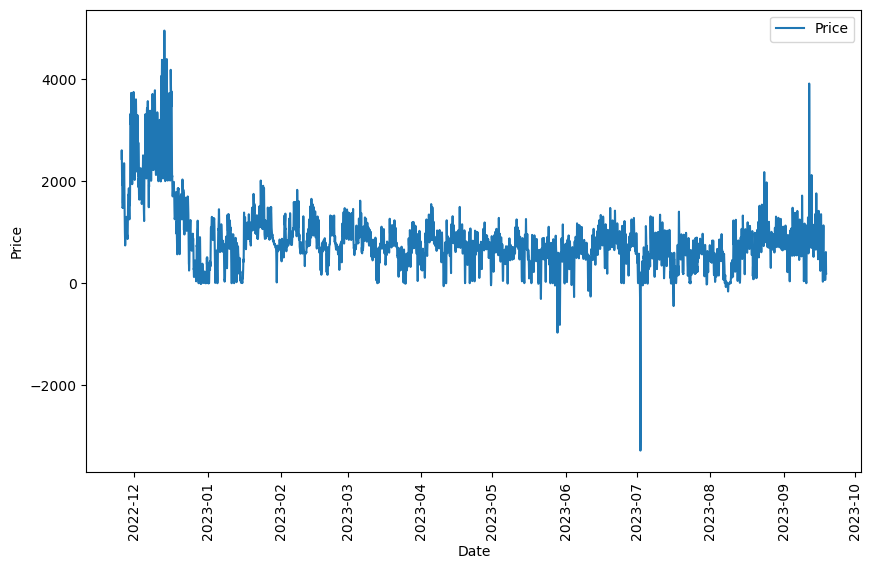

In [107]:
# plot the price with respect to the date
plt.figure(figsize=(10, 6))
plt.plot(test_data['HourDK'], test_data['PriceDKK'], label='Price')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [108]:
df_SOC = get_policy_results(data=test_data, policy=optimal_policy_table, discount_factor=gamma)

df_SOC

Accumulated gain for gamma = 0.99: 4.86e+06


,SOC,Price,Price_cat,Action,Gain,Acc_gain
0,0,2434.439941,Very High,0,0.0000,0.000000e+00
1,0,2602.060059,Very High,Idle,0.0000,0.000000e+00
2,0,2513.189941,Very High,Idle,0.0000,0.000000e+00
3,0,2337.830078,Very High,Idle,0.0000,0.000000e+00
4,0,2038.739990,Very High,Idle,0.0000,0.000000e+00
...,...,...,...,...,...,...
7130,400,410.589996,Very Low,Charge,-41058.9996,4.838336e+06
7131,300,610.030029,Low,Discharge,61003.0029,4.899339e+06
7132,400,222.779999,Very Low,Charge,-22277.9999,4.877061e+06
7133,500,202.419998,Very Low,Charge,-20241.9998,4.856819e+06


From 2022-12-16 12:00:00 to 2022-12-20 16:00:00


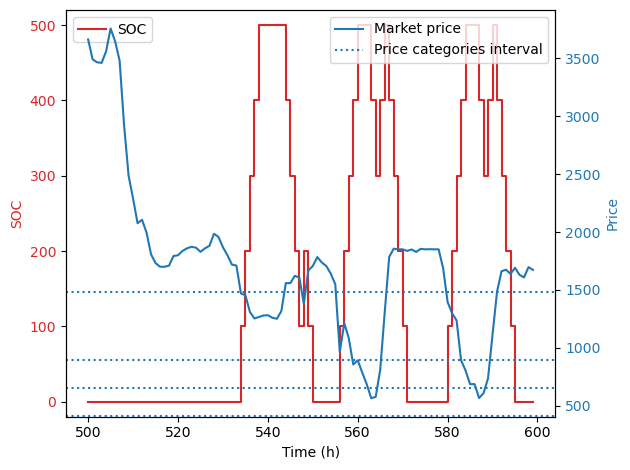

In [109]:
i_start=500
i_end=600

print(f"From {test_data.loc[i_start,'HourDK']} to {test_data.loc[i_end,'HourDK']}")
plot_results(i_start, i_end, policy_results=df_SOC, cat_num=5)

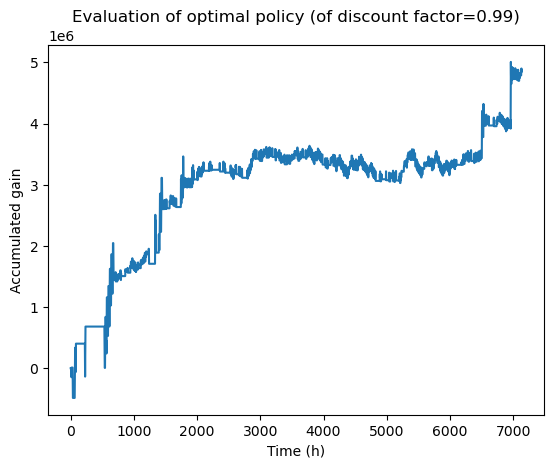

In [110]:
acc_gain = df_SOC["Acc_gain"]
x = df_SOC.index

# Plotting
plt.plot(x, acc_gain)
plt.xlabel('Time (h)')  
plt.ylabel('Accumulated gain')  
plt.title(f'Evaluation of optimal policy (of discount factor={gamma})')

plt.show() 

** **


In [111]:
""" Several values of discount factor (for 5 price categories) """

gamma = [0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.95, 0.96, 0.97, 0.98, 0.99]
optimal_policy = []
optimal_value_function = []

# determine optimal policy for each gamma values
for i in range(len(gamma)):
    policy, value_function = iterate_policy(All_states, Actions, train_data, transition_probability, discount_factor=gamma[i], Power=Power, print_iter=False)

    policy_table = pd.DataFrame(0, index=Price_states, columns=SOC_states)
    for j, (soc, price) in enumerate(All_states):
        policy_table.loc[price, soc] = policy[j]

    optimal_policy.append(policy_table)
    optimal_value_function.append(value_function)

    print(f"Discount factor = {gamma[i]} \n {policy_table} \n")



Discount factor = 0.85 
             0          100        200        300        400        500
Very Low   Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Low        Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Medium     Idle  Discharge  Discharge  Discharge  Discharge  Discharge
High       Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Very High  Idle  Discharge  Discharge  Discharge  Discharge  Discharge 

Discount factor = 0.86 
             0          100        200        300        400        500
Very Low   Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Low        Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Medium     Idle  Discharge  Discharge  Discharge  Discharge  Discharge
High       Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Very High  Idle  Discharge  Discharge  Discharge  Discharge  Discharge 

Discount factor = 0.87 
               0          100        200        300        400        

In [112]:
df_SOC = []

# evaluate each optimal policies
for i in range(len(gamma)):
    df = get_policy_results(test_data, optimal_policy[i], gamma[i])
    df_SOC.append(df)


Accumulated gain for gamma = 0.85: 0.00e+00
Accumulated gain for gamma = 0.86: 0.00e+00
Accumulated gain for gamma = 0.87: 3.04e+06
Accumulated gain for gamma = 0.88: 3.04e+06
Accumulated gain for gamma = 0.89: 8.58e+06
Accumulated gain for gamma = 0.9: 8.58e+06
Accumulated gain for gamma = 0.91: 1.51e+07
Accumulated gain for gamma = 0.92: 2.63e+07
Accumulated gain for gamma = 0.95: 2.63e+07
Accumulated gain for gamma = 0.96: 2.35e+07
Accumulated gain for gamma = 0.97: 1.72e+07
Accumulated gain for gamma = 0.98: 1.73e+07
Accumulated gain for gamma = 0.99: 4.86e+06


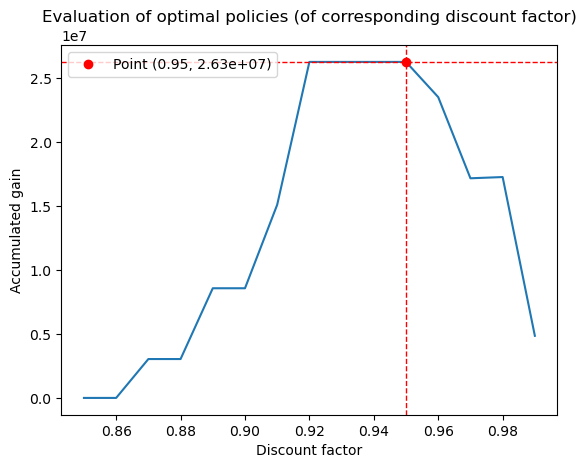

In [113]:
acc_gain = []

# Retrieve accumulated gain
for i in range(len(gamma)):
    acc_gain.append(df_SOC[i]["Acc_gain"][len(df)-1])

# Plotting
plt.plot(gamma, acc_gain)
plt.xlabel('Discount factor')  
plt.ylabel('Accumulated gain')  
plt.title('Evaluation of optimal policies (of corresponding discount factor)')

# Coordinates for the fixed cursor
cursor_y = acc_gain[8]
cursor_x = gamma[8]

# Add vertical and horizontal lines for the cursor
plt.axvline(x=cursor_x, color='red', linestyle='--', linewidth=1)  # Vertical line
plt.axhline(y=cursor_y, color='red', linestyle='--', linewidth=1)  # Horizontal line

# Highlight the intersection point
plt.plot(cursor_x, cursor_y, 'ro', label=f'Point ({cursor_x}, {cursor_y:.2e})')
plt.legend()

plt.show() 

** **

In [114]:
""" Only 3 price categories"""

# defining states
Price_states = ["Very Low", "Medium", "Very High"]
All_states = [(soc, price) for soc in SOC_states for price in Price_states]

# adjusting dataset (60% in medium category) and splitting
raw_data.loc[raw_data['Category'] == 'Low', 'Category'] = 'Medium'
raw_data.loc[raw_data['Category'] == 'High', 'Category'] = 'Medium'

train_data, test_data, validation_data = split_data(raw_data, validation=False)

# get state transition matrix
price_transition_probability, transition_probability = get_transition_matrix(raw_data, SOC_states, Price_states, Power)

In [115]:
# Calculate characteristics of price categories
Price_categories = Price_states

avg = raw_data.groupby('Category')['PriceDKK'].mean().reset_index().sort_values(by='PriceDKK', ascending=True).reset_index(drop=True)
avg_price = {cat: avg['PriceDKK'][Price_categories.index(cat)] for cat in Price_categories}

# Print average prices
for cat in Price_categories:
    print(cat, "- Average:", avg_price[cat])
 

Very Low - Average: 227.97914865125077
Medium - Average: 817.7280566862429
Very High - Average: 2438.8812172703388


In [116]:
""" Discount factor = 0.99 """

gamma = 0.99
start_time = time.time()
optimal_policy, optimal_value_function = iterate_policy(All_states, Actions, train_data, transition_probability, discount_factor=gamma, Power=Power)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"The code took {elapsed_time:.5f} seconds to run.")

optimal_policy_table = pd.DataFrame(0,index=Price_states, columns=SOC_states)
optimal_value_table = pd.DataFrame(0,index=Price_states, columns=SOC_states)

for i, (soc, price) in enumerate(All_states):
    optimal_policy_table.loc[price, soc] = optimal_policy[i]
    optimal_value_table.loc[price, soc] = np.format_float_scientific(optimal_value_function[i], precision=3)

Has converged in 3 iterations.
The code took 0.03100 seconds to run.


In [117]:
optimal_policy_table

,0,100,200,300,400,500
Very Low,Charge,Charge,Charge,Charge,Charge,Idle
Medium,Charge,Charge,Charge,Charge,Charge,Idle
Very High,Idle,Discharge,Discharge,Discharge,Discharge,Discharge


In [118]:
optimal_value_table

,0,100,200,300,400,500
Very Low,9.079e+05,9.508e+05,9.895e+05,1.023e+06,1.052e+06,1.075e+06
Medium,7.642e+05,8.49e+05,9.323e+05,1.015e+06,1.096e+06,1.178e+06
Very High,6.786e+05,9.225e+05,1.151e+06,1.366e+06,1.569e+06,1.759e+06


In [119]:
test_data = test_data.reset_index(drop=True)
test_data

,HourDK,PriceDKK,Category
0,2022-11-25 16:00:00,2434.439941,Very High
1,2022-11-25 17:00:00,2602.060059,Very High
2,2022-11-25 18:00:00,2513.189941,Very High
3,2022-11-25 19:00:00,2337.830078,Very High
4,2022-11-25 20:00:00,2038.739990,Very High
...,...,...,...
7130,2023-09-18 19:00:00,410.589996,Very Low
7131,2023-09-18 20:00:00,610.030029,Medium
7132,2023-09-18 21:00:00,222.779999,Very Low
7133,2023-09-18 22:00:00,202.419998,Very Low


In [120]:
df_SOC = get_policy_results(test_data, optimal_policy_table, gamma)

Accumulated gain for gamma = 0.99: 4.59e+06


From 2022-12-16 12:00:00 to 2022-12-20 16:00:00


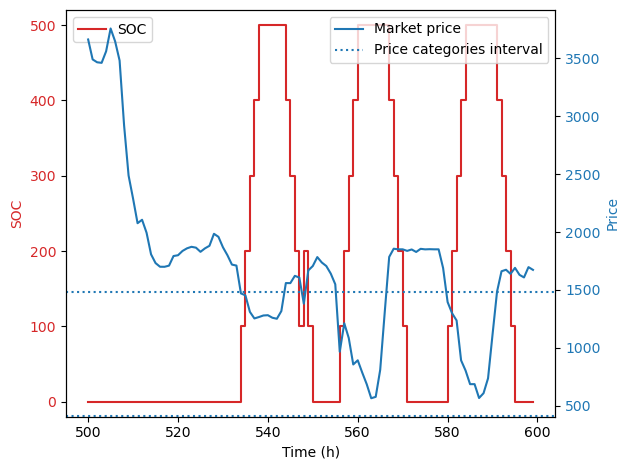

In [121]:
i_start=500
i_end=600

print(f"From {test_data.loc[i_start,'HourDK']} to {test_data.loc[i_end,'HourDK']}")
plot_results(i_start, i_end, policy_results=df_SOC, cat_num=3)

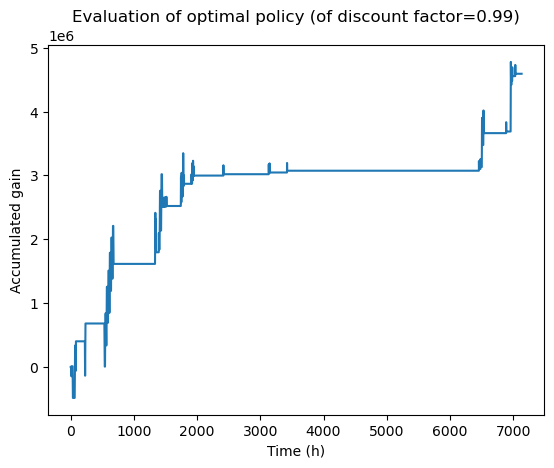

In [122]:
acc_gain = df_SOC["Acc_gain"]
x = df_SOC.index

# Plotting
plt.plot(x, acc_gain)
plt.xlabel('Time (h)')  
plt.ylabel('Accumulated gain')  
plt.title(f'Evaluation of optimal policy (of discount factor={gamma})')

plt.show() 

** **

In [123]:
""" Several values of discount factor (for 3 price categories) """

gamma = [0.8, 0.81, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.96, 0.97, 0.98, 0.99]
optimal_policy = []
optimal_value_function = []

# determine optimal policy for each gamma values
for i in range(len(gamma)):
    policy, value_function = iterate_policy(All_states, Actions, train_data, transition_probability, discount_factor=gamma[i], Power=Power, print_iter=False)

    policy_table = pd.DataFrame(0, index=Price_states, columns=SOC_states)
    for j, (soc, price) in enumerate(All_states):
        policy_table.loc[price, soc] = policy[j]

    optimal_policy.append(policy_table)
    optimal_value_function.append(value_function)

    print(f"Discount factor = {gamma[i]} \n {policy_table} \n")



Discount factor = 0.8 
               0          100        200        300        400        500
Very Low   Charge       Idle  Discharge  Discharge  Discharge  Discharge
Medium       Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Very High    Idle  Discharge  Discharge  Discharge  Discharge  Discharge 

Discount factor = 0.81 
               0          100        200        300        400        500
Very Low   Charge       Idle  Discharge  Discharge  Discharge  Discharge
Medium       Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Very High    Idle  Discharge  Discharge  Discharge  Discharge  Discharge 

Discount factor = 0.83 
               0          100        200        300        400        500
Very Low   Charge     Charge       Idle  Discharge  Discharge  Discharge
Medium       Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Very High    Idle  Discharge  Discharge  Discharge  Discharge  Discharge 

Discount factor = 0.84 
               0    

In [124]:
df_SOC = []

# evaluate each optimal policies
for i in range(len(gamma)):
    df = get_policy_results(test_data, optimal_policy[i], gamma[i])
    df_SOC.append(df)


Accumulated gain for gamma = 0.8: 3.04e+06
Accumulated gain for gamma = 0.81: 3.04e+06
Accumulated gain for gamma = 0.83: 8.58e+06
Accumulated gain for gamma = 0.84: 8.58e+06
Accumulated gain for gamma = 0.85: 1.51e+07
Accumulated gain for gamma = 0.86: 1.51e+07
Accumulated gain for gamma = 0.87: 2.13e+07
Accumulated gain for gamma = 0.88: 2.63e+07
Accumulated gain for gamma = 0.89: 2.63e+07
Accumulated gain for gamma = 0.96: 2.63e+07
Accumulated gain for gamma = 0.97: 2.22e+07
Accumulated gain for gamma = 0.98: 1.18e+07
Accumulated gain for gamma = 0.99: 4.59e+06


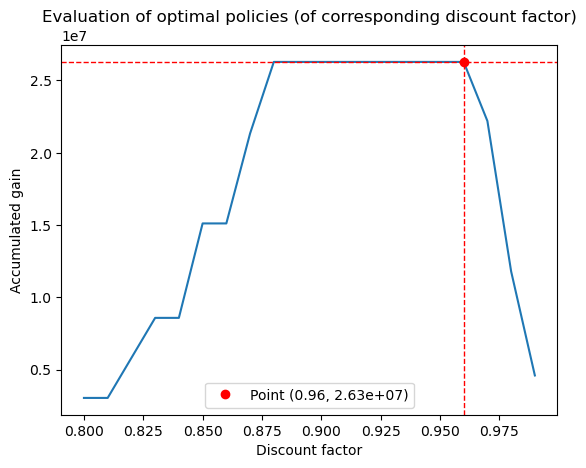

In [125]:
acc_gain = []

# Retrieve accumulated gain
for i in range(len(gamma)):
    acc_gain.append(df_SOC[i]["Acc_gain"][len(df)-1])

# Plotting
plt.plot(gamma, acc_gain)
plt.xlabel('Discount factor')  
plt.ylabel('Accumulated gain')  
plt.title('Evaluation of optimal policies (of corresponding discount factor)')

# Coordinates for the fixed cursor
cursor_y = acc_gain[9]
cursor_x = gamma[9]

# Add vertical and horizontal lines for the cursor
plt.axvline(x=cursor_x, color='red', linestyle='--', linewidth=1)  # Vertical line
plt.axhline(y=cursor_y, color='red', linestyle='--', linewidth=1)  # Horizontal line

# Highlight the intersection point
plt.plot(cursor_x, cursor_y, 'ro', label=f'Point ({cursor_x}, {cursor_y:.2e})')
plt.legend()

plt.show() 

** **

### Value iteration algorithm

In [126]:
def valid_actions(soc_state:int):
    """
    Define the valid actions from current state.
    """
    actions = []
    if soc_state == 0:
        actions = ["Charge", "Idle"]
    elif soc_state == 500:
        actions = ["Idle", "Discharge"]
    else:
        actions = ["Charge", "Idle", "Discharge"]

    return actions

In [127]:
def next_state(soc_state:int, action:str):
    state = 0
    if action == "Charge":
        state = soc_state + Power
    elif action == "Idle":
        state = soc_state
    elif action == "Discharge":
        state = soc_state - Power
    else:
        raise ValueError("Input must be a valid action.")
    
    return state


In [128]:
def value_iteration(states:list[tuple[int,str]], Price_states:list[str], price_transition_probability, discount_factor:float, epsilon=1e-6, print_iter=True):
    """
    Value iteration to calculate optimal value function

    Returns:
        optimal_value_function
    """
    # Initialize the value function with V(s) = 0
    V = np.zeros(len(states))
    iter = 0
    while True:
        iter += 1

        # Initialize the new value function
        V_new = np.zeros(len(states))
        for s in range(len(states)):
            current_soc = states[s][0]
            current_price = states[s][1]
            # Get the valid actions for the current state
            actions = valid_actions(current_soc)
            # Extract the rewards and transitions for the current state
            rewards = {a: reward(avg_price[current_price], a, Power) for a in actions}

            # For each valid action, calculate V(s,p)
            future_value = {a: 0 for a in actions}
            for a in actions:
                futuresum = 0
                next_soc = next_state(current_soc, a)
                for next_price in Price_states:
                    futuresum += price_transition_probability[(current_price,next_price)] * V[states.index((next_soc,next_price))]
                future_value[a] = futuresum           
                        
            # Update the value function
            V_new[s] = np.max([rewards[a] + discount_factor * future_value[a] for a in actions])
        
        # Check for convergence
        if np.max(np.abs(V - V_new)) < epsilon:
            break
        V = V_new

    if print_iter:
        print(f"Has converged in {iter} iterations.")
    return V

In [129]:
def policy_from_value(states, Price_states, price_transition_probability, discount_factor, V):
    """ 
    Calculation of optimal policy from optimal value function

    Returns:
         
    """   
    # Initialize the policy with a random action for each state
    policy = []
    for s in range(len(states)):
        current_soc = states[s][0]
        current_price = states[s][1]
        # Get the valid actions for the current state
        actions = valid_actions(current_soc)
        # Extract the rewards and transitions for the current state
        rewards = {a: reward(avg_price[current_price], a, Power) for a in actions}

        # For each valid action, calculate V(s,p)
        future_value = {a: 0 for a in actions}
        for a in actions:
            futuresum = 0
            next_soc = next_state(current_soc, a)
            for next_price in Price_states:
                futuresum += price_transition_probability[(current_price,next_price)] * V[states.index((next_soc,next_price))]
            future_value[a] = futuresum           
                        
        # Compute the value of each action
        action_values = {a: rewards[a] + discount_factor * future_value[a] for a in actions}
        # Select the action with the highest value
        max_action, max_value = None, float('-inf')
        for key, value in action_values.items():
            if value > max_value:
                max_action, max_value = key, value
        policy.append(max_action)
    return policy

### 3 price categories

In [130]:
""" 3 price categories and data unchanged """

Price_states = ['Very Low', 'Medium', 'Very High']
All_states = [(soc, price) for soc in SOC_states for price in Price_states]
Power = 100

gamma = 0.99

start_time = time.time()
optimal_values = value_iteration(All_states, Price_states, price_transition_probability, gamma)
optimal_policy = policy_from_value(All_states, Price_states, price_transition_probability, gamma, optimal_values)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"The code took {elapsed_time:.5f} seconds to run.")


optimal_value_table = pd.DataFrame(0,index=Price_states, columns=SOC_states)
optimal_policy_table = pd.DataFrame("",index=Price_states, columns=SOC_states)

for i, (soc, price) in enumerate(All_states):
    optimal_value_table.loc[price, soc] = np.format_float_scientific(optimal_values[i], precision=3)
    optimal_policy_table.loc[price, soc] = optimal_policy[i]

Has converged in 2272 iterations.
The code took 1.23564 seconds to run.


In [131]:
optimal_value_table

,0,100,200,300,400,500
Very Low,9.079e+05,9.508e+05,9.895e+05,1.023e+06,1.052e+06,1.075e+06
Medium,7.642e+05,8.49e+05,9.323e+05,1.015e+06,1.096e+06,1.178e+06
Very High,6.786e+05,9.225e+05,1.151e+06,1.366e+06,1.569e+06,1.759e+06


In [132]:
optimal_policy_table

,0,100,200,300,400,500
Very Low,Charge,Charge,Charge,Charge,Charge,Idle
Medium,Charge,Charge,Charge,Charge,Charge,Idle
Very High,Idle,Discharge,Discharge,Discharge,Discharge,Discharge


In [133]:
test_data

,HourDK,PriceDKK,Category
0,2022-11-25 16:00:00,2434.439941,Very High
1,2022-11-25 17:00:00,2602.060059,Very High
2,2022-11-25 18:00:00,2513.189941,Very High
3,2022-11-25 19:00:00,2337.830078,Very High
4,2022-11-25 20:00:00,2038.739990,Very High
...,...,...,...
7130,2023-09-18 19:00:00,410.589996,Very Low
7131,2023-09-18 20:00:00,610.030029,Medium
7132,2023-09-18 21:00:00,222.779999,Very Low
7133,2023-09-18 22:00:00,202.419998,Very Low


In [134]:
df_SOC = get_policy_results(test_data, optimal_policy_table, gamma)

Accumulated gain for gamma = 0.99: 4.59e+06


From 2022-12-16 12:00:00 to 2022-12-20 16:00:00


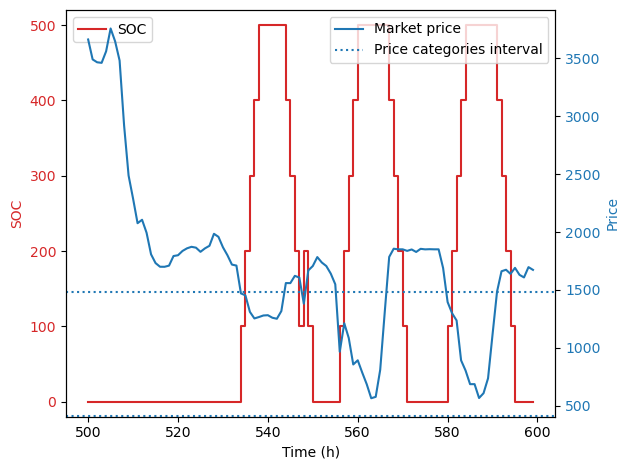

In [135]:
i_start=500
i_end=600

print(f"From {test_data.loc[i_start,'HourDK']} to {test_data.loc[i_end,'HourDK']}")
plot_results(i_start, i_end, policy_results=df_SOC, cat_num=3)

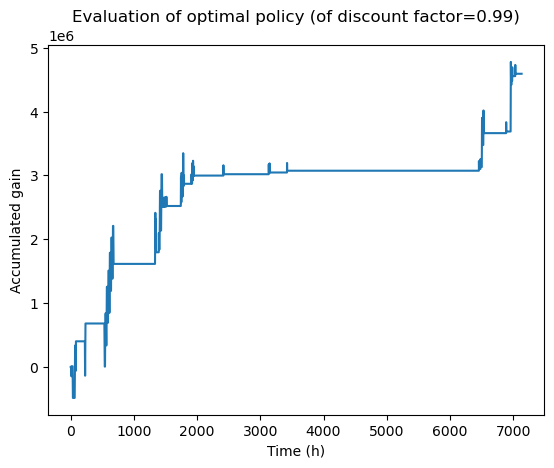

In [136]:
acc_gain = df_SOC["Acc_gain"]
x = df_SOC.index

# Plotting
plt.plot(x, acc_gain)
plt.xlabel('Time (h)')  
plt.ylabel('Accumulated gain')  
plt.title(f'Evaluation of optimal policy (of discount factor={gamma})')

plt.show() 

** **

In [138]:
""" Several values of discount factor (for 3 price categories) """

gamma = [0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.96, 0.97, 0.98, 0.99]
optimal_policy = []
optimal_value_function = []

# determine optimal policy for each gamma values
for i in range(len(gamma)):
    value_function = value_iteration(All_states, Price_states, price_transition_probability, discount_factor=gamma[i], print_iter=False)
    policy = policy_from_value(All_states, Price_states, price_transition_probability, gamma[i], value_function)

    value_table = pd.DataFrame(0,index=Price_states, columns=SOC_states)
    policy_table = pd.DataFrame("",index=Price_states, columns=SOC_states)

    for j, (soc, price) in enumerate(All_states):
        value_table.loc[price, soc] = np.format_float_scientific(value_function[j], precision=3)
        policy_table.loc[price, soc] = policy[j]

    optimal_policy.append(policy_table)
    optimal_value_function.append(value_table)

    print(f"Discount factor = {gamma[i]} \n {policy_table} \n")



Discount factor = 0.8 
               0          100        200        300        400        500
Very Low   Charge       Idle  Discharge  Discharge  Discharge  Discharge
Medium       Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Very High    Idle  Discharge  Discharge  Discharge  Discharge  Discharge 

Discount factor = 0.81 
               0          100        200        300        400        500
Very Low   Charge       Idle  Discharge  Discharge  Discharge  Discharge
Medium       Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Very High    Idle  Discharge  Discharge  Discharge  Discharge  Discharge 

Discount factor = 0.82 
               0          100        200        300        400        500
Very Low   Charge       Idle  Discharge  Discharge  Discharge  Discharge
Medium       Idle  Discharge  Discharge  Discharge  Discharge  Discharge
Very High    Idle  Discharge  Discharge  Discharge  Discharge  Discharge 

Discount factor = 0.83 
               0    

In [139]:
df_SOC = []

# evaluate each optimal policies
for i in range(len(gamma)):
    df = get_policy_results(test_data, optimal_policy[i], gamma[i])
    df_SOC.append(df)


Accumulated gain for gamma = 0.8: 3.04e+06
Accumulated gain for gamma = 0.81: 3.04e+06
Accumulated gain for gamma = 0.82: 3.04e+06
Accumulated gain for gamma = 0.83: 8.58e+06
Accumulated gain for gamma = 0.84: 8.58e+06
Accumulated gain for gamma = 0.85: 1.51e+07
Accumulated gain for gamma = 0.86: 1.51e+07
Accumulated gain for gamma = 0.87: 2.13e+07
Accumulated gain for gamma = 0.88: 2.63e+07
Accumulated gain for gamma = 0.96: 2.63e+07
Accumulated gain for gamma = 0.97: 2.22e+07
Accumulated gain for gamma = 0.98: 1.18e+07
Accumulated gain for gamma = 0.99: 4.59e+06


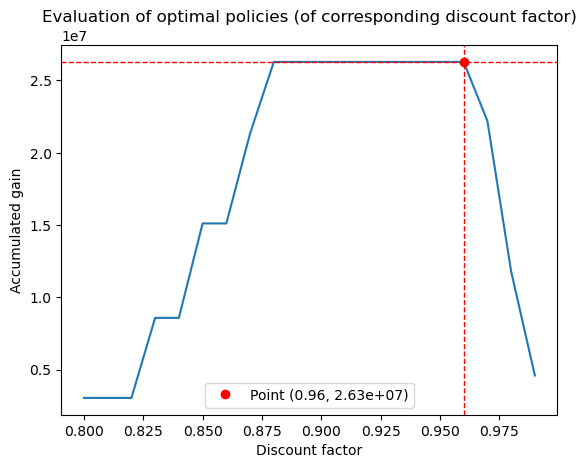

In [140]:
acc_gain = []

# Retrieve accumulated gain
for i in range(len(gamma)):
    acc_gain.append(df_SOC[i]["Acc_gain"][len(df)-1])

# Plotting
plt.plot(gamma, acc_gain)
plt.xlabel('Discount factor')  
plt.ylabel('Accumulated gain')  
plt.title('Evaluation of optimal policies (of corresponding discount factor)')

# Coordinates for the fixed cursor
cursor_y = acc_gain[9]
cursor_x = gamma[9]

# Add vertical and horizontal lines for the cursor
plt.axvline(x=cursor_x, color='red', linestyle='--', linewidth=1)  # Vertical line
plt.axhline(y=cursor_y, color='red', linestyle='--', linewidth=1)  # Horizontal line

# Highlight the intersection point
plt.plot(cursor_x, cursor_y, 'ro', label=f'Point ({cursor_x}, {cursor_y:.2e})')
plt.legend()

plt.show() 